## 1. Importing Libraries

In [30]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from xgboost import XGBRegressor

from feature_engine.datetime import DatetimeFeatures

import joblib
import matplotlib.pyplot as plt
from pathlib import Path

## 2. Display Settings

In [31]:
pd.set_option("display.max_columns", None)

In [32]:
sklearn.set_config(transform_output="pandas")

In [33]:
plt.style.use('fivethirtyeight')

## Getting the Data

In [34]:
home_dir = Path('.').cwd().parent

In [35]:
data_dir = home_dir / "data/raw/"
print(data_dir)

c:\Users\vishpand\Desktop\campusx DS course\12) trial classes\Flask\flight-price-flask-project\data\raw


In [36]:
train_df = pd.read_csv(data_dir / "train.csv")
val_df = pd.read_csv(data_dir / "val.csv")
test_df = pd.read_csv(data_dir / "test.csv")

In [37]:
train_df.head(2)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372


## 3.1 Split the Data

In [38]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X, y)

In [39]:
X_train, y_train = split_data(train_df)
print(f"{X_train.shape = }, {y_train.shape = }")

X_train.shape = (640, 9), y_train.shape = (640,)


In [40]:
type(y_train)

pandas.core.series.Series

In [41]:
X_val, y_val = split_data(val_df)
print(f"{X_val.shape = }, {y_val.shape = }")

X_val.shape = (160, 9), y_val.shape = (160,)


In [42]:
X_test, y_test = split_data(test_df)
print(f"{X_test.shape = }, {y_test.shape = }")

X_test.shape = (200, 9), y_test.shape = (200,)


## 3.2 Meta-info

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [44]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]
num_cols = ["duration", "total_stops"]
cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [45]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [46]:
num_transformer = Pipeline(steps=[
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
 ])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])

In [47]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [48]:
preprocessor.fit_transform(X_train).head(2)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041


## 5. Model Selection

In [49]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [50]:
data = pd.concat([train_df, val_df], axis=0)

In [51]:
data.head(2)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372


In [52]:
X_data, y_data = split_data(data)
print(f"{X_data.shape = }")
print(f"{y_data.shape = }")

X_data.shape = (800, 9)
y_data.shape = (800,)


In [53]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker='o',
        label = label
    )

    ax.fill_between(
        x = sizes,
        y1 = mean_scores - std_scores,
        y2 = mean_scores + std_scores,
        alpha = 0.5
    )

In [54]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X = X_data,
        y = y_data,
        cv = 3,
        scoring = 'r2',
        n_jobs = -1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"


    fig, ax = plt.subplots(figsize=figsize)

    # Training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # Testt curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size",ylabel="R-square", title=name)

    ax.legend(loc="lower right")

    plt.show()

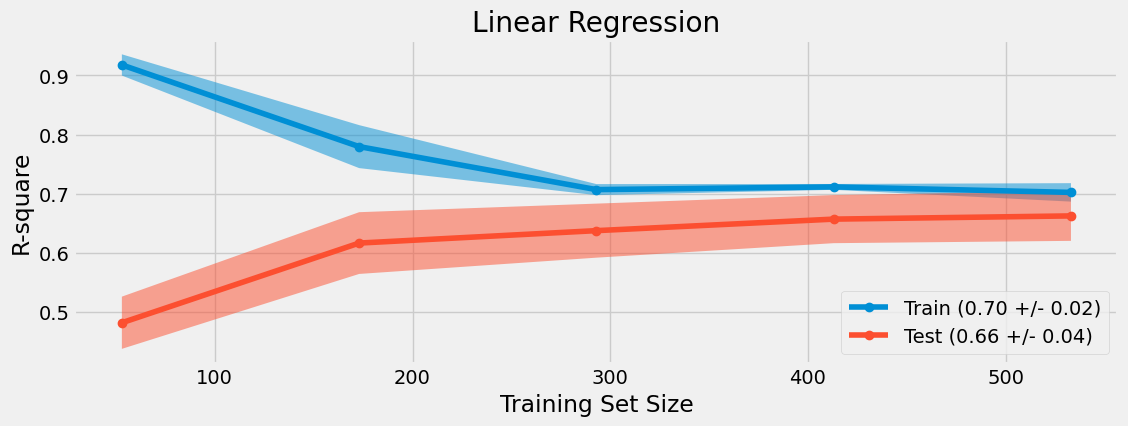

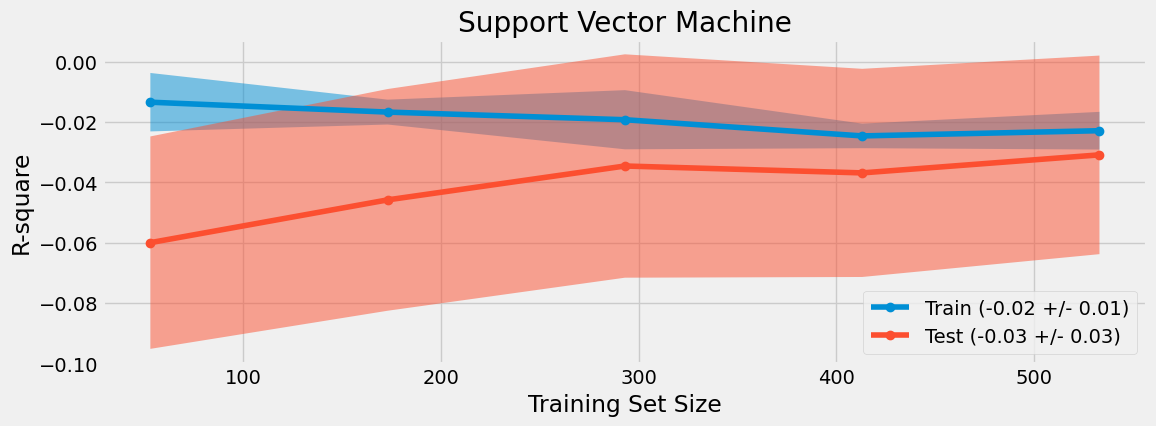

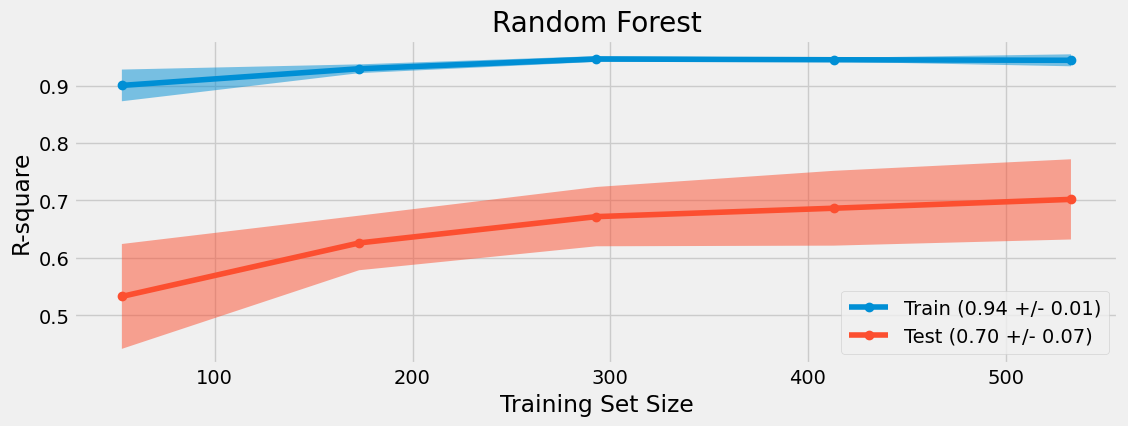

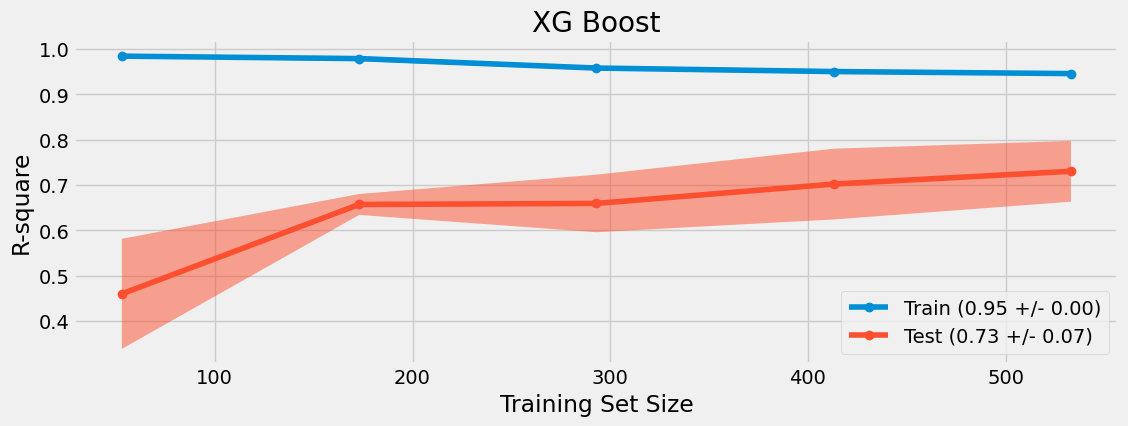

In [55]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

## 6. Model Training

In [56]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])

In [57]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evaluation

In [58]:
def evaluate_model(X, y, label):
    y_pred = model.predict(X)
    print(f"R2 score on {label} data is: {r2_score(y, y_pred):.2f}")
    # return r2_score(y, y_pred)

In [59]:
evaluate_model(X_train, y_train, "Training")

R2 score on Training data is: 0.95


In [60]:
evaluate_model(X_test, y_test, "Test")

R2 score on Test data is: 0.65


## 8. Model Persistence

In [61]:
joblib.dump(model, '../models/model.joblib')

['../models/model.joblib']

In [62]:
saved_model = joblib.load('../models/model.joblib')
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [63]:
evaluate_model(X_test, y_test, "Test")

R2 score on Test data is: 0.65
